In [2]:
import tonic
import tonic.transforms as transforms
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import scipy.signal
from numpy import sin,cos,pi
from scipy.spatial.distance import cdist 
import torch 
from scipy.integrate import cumtrapz
import pandas as pd

# Loading datasets 

dataset = tonic.datasets.VPR(save_to='/Users/theresejoseph/Documents/VRES/VPR_dataset')

query, query_targets = dataset[0]
query_events, query_imu, query_images = query  #680 images

reference, ref_targets = dataset[1]
ref_events, ref_imu, ref_images = reference #1487 images 

ref_and_query=[ref_events, query_events]
smaller_data=len(ref_and_query[np.argmin([len(ref_events),len(query_events)])])

print(query_events)


[(       0, 122, 195, 0) (      12,  36, 172, 0) (      78, 122, 195, 0)
 ... (16999958, 117,   7, 1) (16999958,  32, 107, 1)
 (16999961,  95,  71, 1)]


In [3]:
indoor_events_query=np.asarray(pd.read_feather('/Users/theresejoseph/Documents/VRES/VPR_dataset/bags_2021-08-19-08-25-42_denoised.feather'))
indoor_events_ref=np.asarray(pd.read_feather('/Users/theresejoseph/Documents/VRES/VPR_dataset/bags_2021-08-19-08-28-43_denoised.feather'))

print(pd.read_feather('/Users/theresejoseph/Documents/VRES/VPR_dataset/bags_2021-08-19-08-25-42_denoised.feather'))

                         t    x    y  p
0         1629325542892574  323   42  1
1         1629325542892599  276   18  0
2         1629325542892605  280   44  0
3         1629325542892629  256   71  0
4         1629325542892662  329   35  1
...                    ...  ...  ... ..
37105396  1629325710083737  244   12  0
37105397  1629325710083737  137   47  1
37105398  1629325710083737   58  142  1
37105399  1629325710083738  236    7  1
37105400  1629325710083738  127   63  1

[37105401 rows x 4 columns]


### IMU Processing 

In [4]:
# Handling IMU data 
def imu_processing():
    accelX,accelY,accelZ=ref_imu['acc'][:,0],ref_imu['acc'][:,1],ref_imu['acc'][:,2]
    magReadX,magReadY,magReadZ=ref_imu['mag'][:,0],ref_imu['mag'][:,1],ref_imu['mag'][:,2]
    angVX,angVY,angVZ=ref_imu['angV'][:,0],ref_imu['angV'][:,1],ref_imu['angV'][:,2]

    roll, pitch, yaw = np.empty(accelX.shape),np.empty(accelX.shape),np.empty(accelX.shape)
    for i in range(len(accelX)):
        pitch[i] = 180 * math.atan2(accelX[i], math.sqrt(accelY[i]*accelY[i] + accelZ[i]*accelZ[i]))/pi
        roll[i] = 180 * math.atan2(accelY[i], math.sqrt(accelX[i]*accelX[i] + accelZ[i]*accelZ[i]))/pi

        mag_x = magReadX[i]*cos(pitch[i]) + magReadY[i]*sin(roll[i])*sin(pitch[i]) + magReadZ[i]*cos(roll[i])*sin(pitch[i])
        mag_y = magReadY[i] * cos(roll[i]) - magReadZ[i] * sin(roll[i])
        yaw [i]= 180 * math.atan2(-mag_y,mag_x)/pi

    dt=ref_imu['ts'][1]-ref_imu['ts'][0]
    x =cumtrapz(cumtrapz(accelX,dx=dt),dx=dt)
    y =cumtrapz(cumtrapz(accelY,dx=dt),dx=dt)
    z =cumtrapz(cumtrapz(accelZ,dx=dt),dx=dt)

    angX=cumtrapz(angVX,dx=dt)
    angY=cumtrapz(angVY,dx=dt)
    angZ=cumtrapz(angVZ,dx=dt)
    #print(ref_imu)
    return x,y,z,angX,angY,angZ

'''fig1,ax = plt.subplots()
fig1.suptitle('3D Trajectory of Events',fontsize=10)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=5)
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')


fig2, ax = plt.subplots()
fig1.suptitle('3D Trajectory of Events',fontsize=10)
ax1 = plt.axes(projection='3d')
ax1.plot3D(angX,angY,angZ,c='blue',lw=5)
ax1.set_xlabel('X angle (rad)')
ax1.set_ylabel('Y angle (rad)')'''



"fig1,ax = plt.subplots()\nfig1.suptitle('3D Trajectory of Events',fontsize=10)\nax = plt.axes(projection='3d')\nax.plot3D(x,y,z,c='red',lw=5)\nax.set_xlabel('X position (m)')\nax.set_ylabel('Y position (m)')\n\n\nfig2, ax = plt.subplots()\nfig1.suptitle('3D Trajectory of Events',fontsize=10)\nax1 = plt.axes(projection='3d')\nax1.plot3D(angX,angY,angZ,c='blue',lw=5)\nax1.set_xlabel('X angle (rad)')\nax1.set_ylabel('Y angle (rad)')"

### Event Slicing

In [5]:
##########################################################################################
'''ref_mean_diff = np.diff(list(zip(ref_images["ts"], ref_images["ts"][1:]))).mean()
print("Mean reference difference is " + str(ref_mean_diff))
query_mean_diff = np.diff(list(zip(query_images["ts"], query_images["ts"][1:]))).mean()
print("Mean query difference is " + str(query_mean_diff))'''
def gpsForEvents(events,targets):
    eventsPerGPS=len(events)//len(targets)
    lat_longR=np.asarray(np.add([elem[0] for elem in targets],[elem[1] for elem in targets]))

    gps=[0]*((len(events)))
    for i in range(0,len(events),eventsPerGPS):
        if (i+eventsPerGPS)>len(events)-1:
                break 
        gps[i:i+eventsPerGPS]=lat_longR[i//eventsPerGPS]*np.ones((eventsPerGPS))
    return gps

sensor_size = tonic.datasets.VPR.sensor_size
print(sensor_size)

def event_slice(start, end, events):
    
    events_frame=np.zeros((sensor_size[1],sensor_size[0]))+2
    for i in range(start, end):
        events_frame[events[i][2], events[i][1]]=events[i][3]
    event_frame_filter=scipy.signal.medfilt2d(events_frame, 3)
    return event_frame_filter

def eventSlicedForImages(events, image_len):
    events_per_Frame=int(len(events)/image_len)
    events_frame_all=[0]*680
    for num in range(0, len(events),events_per_Frame):
        if (num//events_per_Frame)>679:
            break 
        events_frame_all[(num//events_per_Frame)]=event_slice(num, num+events_per_Frame, events)
    return events_frame_all

#print('There are %d images and %d events producing %d events per image' % (len(images["frames"]), len(events), int((len(events)/len(images["frames"])))))
'''events_frame_ref=eventSlicedForImages(ref_events, len(ref_images["frames"]))
events_frame_query=eventSlicedForImages(query_events, len(query_images["frames"]))'''

def eventSliceTime(events,sliceTime):
    #lat_long=gpsForEvents(events,target)
    n_slices = int(np.floor(((events[-1][0] - events[0][0]) - sliceTime) / sliceTime) + 1)
    eventsPerFrame=len(events)//n_slices

    events_frame_all=[0]*n_slices
    #frame_gps=[0]*n_slices

    for num in range(0, len(events),eventsPerFrame):
        times=events[num][1]
        if (num//eventsPerFrame)>n_slices-1:
            break 
        events_frame_all[(num//eventsPerFrame)]=event_slice(num, num+eventsPerFrame, events)
        #frame_gps[(num//eventsPerFrame)]=lat_long[num]

    return events_frame_all



'''def eventSliceTime(events, sliceTime ):
    #slice time in microseconds

    times=np.asarray([elem[0] for elem in events])#time for every event

    closest_time_idxs=[]
    for i in range(0,times[-1],sliceTime):
        closest_time_idxs.append((np.abs(times - i)).argmin())

    events_frame_all=[0]*(len(closest_time_idxs))
    for i in range(0, len(closest_time_idxs)-1):
        events_frame_all[i]=event_slice(closest_time_idxs[i], closest_time_idxs[i+1], events)

    return events_frame_all'''

events_frame_ref=eventSliceTime(indoor_events_ref, 100000)
events_frame_query=eventSliceTime(indoor_events_query, 100000)

print(len(events_frame_ref))
print(len(events_frame_query))

(346, 260, 2)
1641
1671


In [6]:
with open('precomputed.npy', 'wb') as f:
    np.save(f, events_frame_ref)

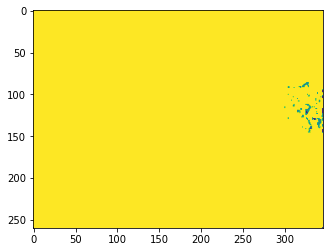

In [7]:
event_ref=eventSliceTime(ref_events,5000)
plt.imshow(event_ref[0])
plt.show()

### Distance Matrix 

In [8]:
sensor_size = tonic.datasets.VPR.sensor_size
feats_ref=np.zeros((len(events_frame_ref),sensor_size[0]*sensor_size[1]))
feats_qry=np.zeros((len(events_frame_ref),sensor_size[0]*sensor_size[1]))
for i in range(0,len(events_frame_ref)):
    feats_ref[i,:]=(events_frame_ref[i].flatten())
    feats_qry[i,:]=(events_frame_query[i].flatten())



[   9  350  618 ...  709 1545 1368]
Error: 921792


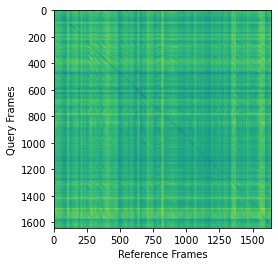

In [9]:
dMat = cdist(feats_ref,feats_qry,'euclidean')
mInds = np.argsort(dMat,axis=1)[0] # shape: K x ft_qry.shape[0]
expected=np.arange(0,len(mInds))
print(mInds)

print("Error: "+ str(sum(abs(expected-mInds))))
plt.imshow(dMat)
plt.xlabel("Reference Frames")
plt.ylabel("Query Frames")
plt.show()

[ 580  580  580 ... 1601 1602 1603]
Error: 225426


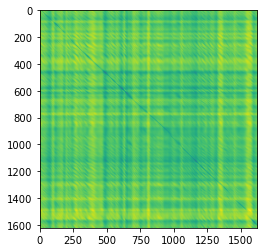

In [10]:
seq_len=20
from scipy import signal
convdMat=np.array(signal.convolve2d(dMat, np.identity(seq_len,dtype=int), mode='valid'))
mIndSeqs = np.argmin(convdMat,axis=0)
print(mIndSeqs)
expected=np.arange(0,len(mIndSeqs))


print("Error: " + str(sum(abs(expected-mIndSeqs))))

plt.imshow(convdMat) 
plt.show()


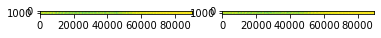

In [11]:
fig, (ax1, ax2)=plt.subplots(1,2)
ax1.imshow(feats_ref)
ax2.imshow(feats_qry)
plt.show()

In [12]:
# #qry_seq=np.array(feats_qry)[50:53,:]
# seq_len=7

# def seq_matching(feats_ref,qry_seq,seq_len):
#     diagOnes=np.identity(seq_len,dtype=int)
#     modSeq=seq_len*(len(feats_ref)//seq_len)
#     dMat_new = cdist(qry_seq,feats_ref,'euclidean')

#     #diag_dMat=np.zeros((seq_len,modSeq-seq_len))
#     sum_diag=np.zeros(modSeq-seq_len+1)
#     for i in range(0,modSeq):
#         #diag_dMat[:,i:i+seq_len]=(dMat_new[:,i:i+seq_len]*diagOnes)
#         sum_diag[i]=np.sum(dMat_new[:,i:i+seq_len]*diagOnes)
#         if i+seq_len==modSeq:
#             break
#     minIdx=np.argmin(sum_diag)
#     return minIdx


# def matching_dataset(feats_ref,feats_qry,seq_len):
#     modSeq=seq_len*(len(feats_ref)//seq_len)
#     idx=np.zeros(modSeq)
#     for i in range(0,modSeq):
#         #print(i)
#         idx[i]=seq_matching(feats_ref,np.array(feats_qry)[i:i+seq_len,:],seq_len)
#         if i+seq_len==modSeq:
#             break
#         #print(np.array(range(idx,idx+seq_len), dtype=int))
#         #indexes[i:i+seq_len]=np.array(range(idx,idx+seq_len))
#     return idx
# idxs=matching_dataset(feats_ref,feats_qry,seq_len).astype(int)

# # plt.imshow(diag_dMat[:,0:100])
# # plt.show()

## Main 

In [13]:
# #print(events_frame_query[168]) #169-1
# #print(events_frame_ref[388]) #389-1

# '''feats_ref=[]
# feats_qry=[]
# for i in range(0,len(events_frame_query)):
#     feats_ref.append(events_frame_ref[i].flatten())
#     feats_qry.append(events_frame_query[i].flatten())
# dMat = cdist(feats_ref,feats_qry,'euclidean')
# mInds = np.argsort(dMat,axis=0)[0] # shape: K x ft_qry.shape[0]'''



# ## Matching query and refenernce with visualisation 
# def matchEvents(qry_Idx, events_frame_ref,events_frame_query):
#     #Sum of differences for each individual frame
#     '''sumDiff=np.zeros(len(events_frame_ref))
#     dMat=np.zeros(len(events_frame_ref))
#     for j in range(0,len(events_frame_ref)):
#         sumDiff[j]=np.sum(np.abs(events_frame_ref[j]-events_frame_query[qry_Idx]))
#     minIdx=np.argmin(sumDiff)


#     qry=events_frame_query[qry_Idx]
#     gndt=events_frame_ref[qry_Idx]
#     match=events_frame_ref[minIdx]
#     idx_diff = abs(qry_Idx - minIdx)'''

#     #Flattening and grouping all events together
#     mInds = np.argsort(dMat,axis=0)[0] # shape: K x ft_qry.shape[0]
#     #gndtIdx = (np.abs(gps_ref - gps_query[qry_Idx])).argmin()

#     #Final query reference, match and index difference
#     qry=events_frame_query[qry_Idx]
#     gndt=events_frame_ref[qry_Idx]
#     match=events_frame_ref[mInds[qry_Idx]]

#     # SeqSLAM
#     '''dist_matrix_seqslam=apply_seqSLAM(5, dMat)
#     mInds_seqSlam = np.argsort(dist_matrix_seqslam,axis=0)[0] # shape: K x ft_qry.shape[0]
#     '''
    
#     return qry, gndt, match


#### Visualize matches 

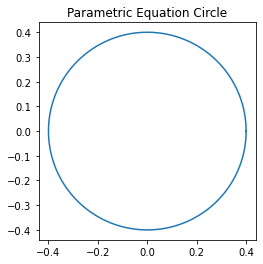

In [14]:
theta = np.linspace( 0 , 2 * np.pi , len(feats_ref) )
 
radius = 0.4
 
x = radius * np.cos( theta )
y = radius * np.sin( theta )
 
figure, axes = plt.subplots( 1 )
 
axes.plot( x,y )
axes.set_aspect( 1 )
 
plt.title( 'Parametric Equation Circle' )
plt.show()

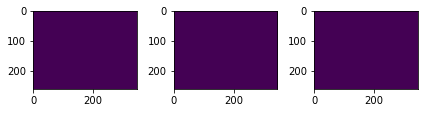

In [15]:
sensor_size = tonic.datasets.VPR.sensor_size
blank=np.zeros((sensor_size[1],sensor_size[0]))
fig3, (ax1, ax2, ax3)= plt.subplots(1,3)
fig3.set_tight_layout(True)
ax1.imshow(blank, animated=True)
ax2.imshow(blank, animated=True)
ax3.imshow(blank, animated=True)

def processTraverses(i):
    qry, gndt, match, idx_diff= matchEvents(i, events_frame_ref,events_frame_query)
    ax1.set_title("Query Event")
    if idx_diff <= 5:
        ax2.set_title("Correct Match Refernce")
    else:
        ax2.set_title("Incorrect Match Reference")
    ax3.set_title("Ground Truth")

    ax1.imshow(qry, animated=True)
    ax2.imshow(match, animated=True)
    ax3.imshow(gndt, animated=True)

anim = animation.FuncAnimation(fig3, processTraverses, frames=168, interval = 20)

plt.show()


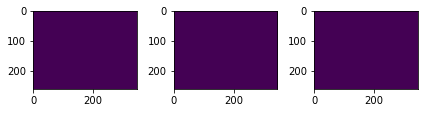

In [16]:
sensor_size = tonic.datasets.VPR.sensor_size
blank=np.zeros((sensor_size[1],sensor_size[0]))
fig4, (ax1, ax2, ax3)= plt.subplots(1,3)
fig4.set_tight_layout(True)
ax1.imshow(blank, animated=True)
ax2.imshow(blank, animated=True)
ax3.imshow(blank, animated=True)
# ax1.imshow(blank, animated=True)
# ax2.imshow(blank, animated=True)
# ax3.imshow(blank, animated=True)

def processSeqTraverses(i):
    qry=events_frame_query[i]
    gndt=events_frame_ref[i]
    match=events_frame_ref[idxs[i]]
    ax1.set_title("Query Event: "+ str(i))
    ax2.set_title( " Match: " +str(mInds[i]))
    ax3.set_title("Ground Truth")

    ax1.imshow(qry, animated=True)
    ax2.imshow(match, animated=True)
    ax3.imshow(gndt, animated=True)

anim = animation.FuncAnimation(fig3, processSeqTraverses, frames=168, interval = 20)

plt.show()

In [17]:
'''fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(events_frame_all[100], animated=True)
ax1.set_title("event frame")
ax2.imshow(images["frames"][100], cmap=mpl.cm.gray, animated=True)
ax2.set_title("grey level image")
plt.show()'''

'''fig, (ax1, ax2)= plt.subplots(1,2)
fig.set_tight_layout(True)
ax1.imshow(events_frame_ref[0], animated=True)
ax2.imshow(events_frame_query[0], animated=True)

def update(i):
    ax1.set_title("Reference event frame")
    ax2.set_title("Query event frames")
    ax1.imshow(events_frame_ref[i], animated=True)
    ax2.imshow(events_frame_query[i], animated=True)
anim = animation.FuncAnimation(fig, update, frames=1487, interval = 20)
plt.show()'''

'fig, (ax1, ax2)= plt.subplots(1,2)\nfig.set_tight_layout(True)\nax1.imshow(events_frame_ref[0], animated=True)\nax2.imshow(events_frame_query[0], animated=True)\n\ndef update(i):\n    ax1.set_title("Reference event frame")\n    ax2.set_title("Query event frames")\n    ax1.imshow(events_frame_ref[i], animated=True)\n    ax2.imshow(events_frame_query[i], animated=True)\nanim = animation.FuncAnimation(fig, update, frames=1487, interval = 20)\nplt.show()'